# Simple Interpretable Baseline
**TF-IDF + Logistic Regression**

This notebook implements a simple and interpretable baseline model for predicting:
- Career domain (department)
- Seniority level

The predictions are based solely on the text of the current (ACTIVE) LinkedIn position.


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report


## Data loading

We load the labeled LinkedIn CV data and keep only the current (ACTIVE) position.
The text input for the model is constructed from the job title and job description.


In [3]:
# Load main labeled dataset
df = pd.read_csv("/content/department-v2.csv")
df.head()


,text,label
0,Adjoint directeur communication,Marketing
1,Advisor Strategy and Projects,Project Management
2,Beratung & Projekte,Project Management
3,Beratung & Projektmanagement,Project Management
4,Beratung und Projektmanagement kommunale Partner,Project Management


In [4]:
df.columns


Index(['text', 'label'], dtype='object')

In [5]:
df.sample(5)


,text,label
795,Consultant (Data Scientist/CRM),Information Technology
3014,Sales and Projects,Sales
8948,Sales- & Marketing-Manager,Marketing
1129,Chargée de Projet Marketing Digital - Communic...,Marketing
6789,Customer Care (Leiter Vertrieb),Sales


In [6]:
# Features (text) and target (label)
X = df["text"]
y = df["label"]

print("Number of samples:", len(df))
print("Number of classes:", y.nunique())
y.value_counts().head(10)


Number of samples: 10145
Number of classes: 11


,count
label,
Marketing,4295
Sales,3328
Information Technology,1305
Business Development,620
Project Management,201
Consulting,167
Administrative,83
Other,42
Purchasing,40


In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


Train size: 8116
Test size: 2029


In [8]:
domain_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced"
    ))
])


In [9]:
domain_model.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [10]:
y_pred = domain_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred))


Accuracy: 0.9310004928536225
Macro F1: 0.8468965684582959

Classification report:

                        precision    recall  f1-score   support

        Administrative       0.59      0.94      0.73        17
  Business Development       0.80      0.99      0.88       124
            Consulting       0.80      1.00      0.89        33
      Customer Support       0.88      1.00      0.93         7
       Human Resources       0.75      1.00      0.86         6
Information Technology       0.92      0.95      0.93       261
             Marketing       0.99      0.92      0.96       859
                 Other       0.44      1.00      0.62         8
    Project Management       0.58      0.88      0.70        40
            Purchasing       0.88      0.88      0.88         8
                 Sales       0.96      0.92      0.94       666

              accuracy                           0.93      2029
             macro avg       0.78      0.95      0.85      2029
          weighted 

In [12]:
tfidf = domain_model.named_steps["tfidf"]
clf = domain_model.named_steps["clf"]

feature_names = tfidf.get_feature_names_out()

for i, class_label in enumerate(clf.classes_[:5]):  # show first 5
    top_idx = np.argsort(clf.coef_[i])[-10:]
    print(f"\nTop words for class '{class_label}':")
    for idx in top_idx:
        print("  ", feature_names[idx])



Top words for class 'Administrative':
   der geschäftsführung
   geschäftsführung
   gf
   assistent der
   geschäftsleitung
   der
   sekretärin
   assistent
   assistenz
   assistentin

Top words for class 'Business Development':
   digital business
   analyst
   business intelligence
   of business
   business process
   ebusiness
   it business
   development
   business development
   business

Top words for class 'Consulting':
   sap
   coach
   hr consultant
   von
   senior consultant
   senior
   recruitment
   beraterin
   berater
   consultant

Top words for class 'Customer Support':
   management support
   customer
   technical
   it support
   it supporter
   it
   customer support
   technical support
   supporter
   support

Top words for class 'Human Resources':
   director digital
   interim management
   project director
   gl
   manager hr
   of human
   human resources
   resources
   human
   hr


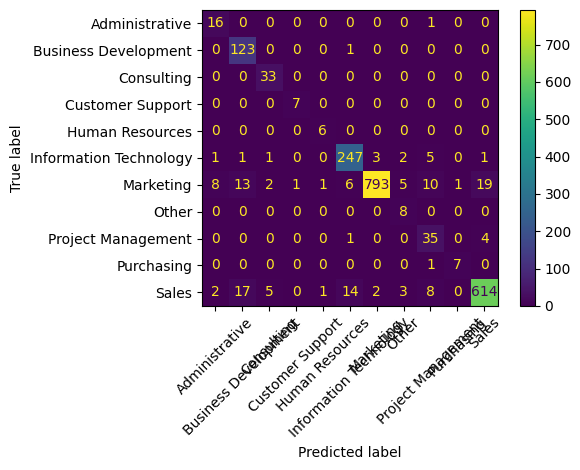

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(domain_model, X_test, y_test, xticks_rotation=45)
plt.tight_layout()
plt.show()


In [14]:
def top_words_table(model, class_name, top_n=15):
    tfidf = model.named_steps["tfidf"]
    clf = model.named_steps["clf"]
    feature_names = np.array(tfidf.get_feature_names_out())

    class_index = list(clf.classes_).index(class_name)
    coefs = clf.coef_[class_index]

    top_idx = np.argsort(coefs)[-top_n:][::-1]
    return pd.DataFrame({
        "word/ngram": feature_names[top_idx],
        "weight": coefs[top_idx]
    })

# example: top words for Marketing and Sales
top_words_table(domain_model, "Marketing", 15)


,word/ngram,weight
0,marketing,15.995660
1,communication,3.173058
2,communications,3.073503
3,messe,2.924233
4,kommunikation,2.686532
5,sales marketing,2.324161
6,marketing manager,2.099168
7,messen,1.988857
8,marketing sales,1.646603
9,marketing und,1.548974


In [15]:
top_words_table(domain_model, "Sales", 15)


,word/ngram,weight
0,sales,12.338490
1,vertrieb,8.243464
2,salesforce,4.920700
3,vertriebsleiter,4.438025
4,account manager,2.382165
5,vertriebsinnendienst,2.278154
6,vertriebsleitung,2.272260
7,of sales,1.991410
8,sales manager,1.939916
9,account,1.799630


In [16]:
import joblib, json, os

os.makedirs("outputs", exist_ok=True)

# save model
joblib.dump(domain_model, "outputs/domain_tfidf_lr.joblib")

# save metrics
metrics = {
    "accuracy": float(accuracy_score(y_test, y_pred)),
    "macro_f1": float(f1_score(y_test, y_pred, average="macro"))
}
with open("outputs/domain_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved to outputs/")


Saved to outputs/


Seniority model

In [17]:
# Load seniority labels
df_sen = pd.read_csv("/content/seniority-v2.csv")
df_sen.head()


,text,label
0,Analyst,Junior
1,Analyste financier,Junior
2,Anwendungstechnischer Mitarbeiter,Junior
3,Application Engineer,Senior
4,Applications Engineer,Senior


In [18]:
df_sen.columns
df_sen.sample(5)


,text,label
3511,Teamleiter SAP Personalberatung,Lead
4428,Assistentin der Geschäftsleitung/Qualitätsmana...,Lead
3329,Niederlassungsleiter Bayern,Lead
2574,Head of IT Cross Applications,Lead
3781,Projektleiter CRM Salesforce,Lead


In [19]:
X_sen = df_sen["text"]
y_sen = df_sen["label"]

print("Samples:", len(df_sen))
print("Classes:", y_sen.nunique())
y_sen.value_counts()


Samples: 9428
Classes: 5


,count
label,
Senior,3733
Lead,3546
Director,984
Management,756
Junior,409


In [20]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_sen,
    y_sen,
    test_size=0.2,
    random_state=42,
    stratify=y_sen
)


In [21]:
seniority_model = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.95
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced"
    ))
])

seniority_model.fit(X_train_s, y_train_s)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [22]:
y_pred_s = seniority_model.predict(X_test_s)

print("Accuracy:", accuracy_score(y_test_s, y_pred_s))
print("Macro F1:", f1_score(y_test_s, y_pred_s, average="macro"))
print(classification_report(y_test_s, y_pred_s))


Accuracy: 0.9708377518557795
Macro F1: 0.9579651200884726
              precision    recall  f1-score   support

    Director       0.99      0.98      0.99       197
      Junior       0.86      1.00      0.93        82
        Lead       0.97      0.98      0.98       709
  Management       0.93      0.92      0.92       151
      Senior       0.99      0.96      0.98       747

    accuracy                           0.97      1886
   macro avg       0.95      0.97      0.96      1886
weighted avg       0.97      0.97      0.97      1886



In [23]:
tfidf_s = seniority_model.named_steps["tfidf"]
clf_s = seniority_model.named_steps["clf"]

feature_names_s = tfidf_s.get_feature_names_out()

for i, class_label in enumerate(clf_s.classes_):
    top_idx = np.argsort(clf_s.coef_[i])[-10:]
    print(f"\nTop words for seniority '{class_label}':")
    for idx in top_idx:
        print(" ", feature_names_s[idx])



Top words for seniority 'Director':
  managing directors
  managing
  director of
  director marketing
  vertriebsdirektor
  abteilungsdirektor
  directors
  director sales
  sales director
  director

Top words for seniority 'Junior':
  marketing
  assistent
  associate
  assistentin
  mitarbeiter
  mitarbeiterin
  referent
  referentin
  analyst
  junior

Top words for seniority 'Lead':
  bereichsleiter
  projektleiter
  geschäftsleitung
  teamleiter
  leiterin
  head of
  head
  vertriebsleiter
  leitung
  leiter

Top words for seniority 'Management':
  president
  vice president
  vice
  founder
  chief
  owner
  geschäftsführung
  ceo
  vp
  geschäftsführer

Top words for seniority 'Senior':
  marketing manager
  engineer
  executive
  assistant
  managerin
  responsable
  consultant
  management
  senior
  manager


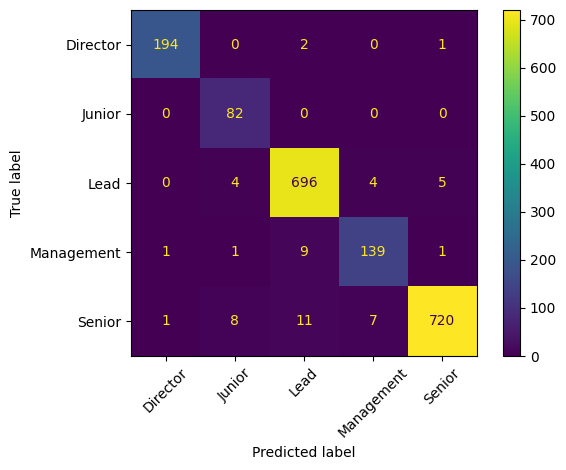

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

ConfusionMatrixDisplay.from_estimator(seniority_model, X_test_s, y_test_s, xticks_rotation=45)
plt.tight_layout()
plt.show()


In [25]:
def top_words_table(model, class_name, top_n=15):
    tfidf = model.named_steps["tfidf"]
    clf = model.named_steps["clf"]
    feature_names = np.array(tfidf.get_feature_names_out())

    class_index = list(clf.classes_).index(class_name)
    weights = clf.coef_[class_index]
    top_idx = np.argsort(weights)[-top_n:][::-1]

    return pd.DataFrame({
        "ngram": feature_names[top_idx],
        "weight": weights[top_idx]
    })

top_words_table(seniority_model, "Director", 15)


,ngram,weight
0,director,15.779174
1,sales director,2.375637
2,director sales,2.319269
3,directors,2.310657
4,abteilungsdirektor,2.257118
5,vertriebsdirektor,2.154550
6,director marketing,1.871336
7,director of,1.544624
8,managing,1.528649
9,managing directors,1.460152


In [26]:
top_words_table(seniority_model, "Junior", 15)
top_words_table(seniority_model, "Lead", 15)


,ngram,weight
0,leiter,6.019712
1,leitung,5.355405
2,vertriebsleiter,3.713346
3,head,3.517578
4,head of,3.372125
5,leiterin,3.020980
6,teamleiter,2.976079
7,geschäftsleitung,2.686818
8,projektleiter,2.571619
9,bereichsleiter,2.278641


In [27]:
import os, json, joblib

os.makedirs("outputs", exist_ok=True)

# save models
joblib.dump(domain_model, "outputs/domain_tfidf_lr.joblib")
joblib.dump(seniority_model, "outputs/seniority_tfidf_lr.joblib")

# save metrics
results = {
    "domain": {
        "accuracy": float(accuracy_score(y_test, y_pred)),
        "macro_f1": float(f1_score(y_test, y_pred, average="macro"))
    },
    "seniority": {
        "accuracy": float(accuracy_score(y_test_s, y_pred_s)),
        "macro_f1": float(f1_score(y_test_s, y_pred_s, average="macro"))
    }
}
with open("outputs/baseline_results.json", "w") as f:
    json.dump(results, f, indent=2)

print("Saved models + metrics to /outputs")


Saved models + metrics to /outputs


Bonus part

In [28]:
import json
import pandas as pd
import numpy as np


In [29]:
def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def extract_active_rows(data):
    """
    Returns a flat table with one row per ACTIVE position:
    person_index, position_index, organization, position, status, startDate, endDate
    """
    rows = []
    for pi, person in enumerate(data):
        # some datasets store positions in person["positions"], some may already be a list
        positions = person.get("positions", None)
        if positions is None and isinstance(person, list):
            positions = person
        if positions is None:
            # fallback: maybe the person itself IS a position dict
            positions = [person] if isinstance(person, dict) else []

        for pj, pos in enumerate(positions):
            status = str(pos.get("status", "")).upper().strip()
            if status == "ACTIVE":
                rows.append({
                    "person_index": pi,
                    "position_index": pj,
                    "organization": pos.get("organization", ""),
                    "position": pos.get("position", ""),
                    "status": status,
                    "startDate": pos.get("startDate", ""),
                    "endDate": pos.get("endDate", ""),
                    # keep original fields if present
                    "department_true": pos.get("department", None),
                    "seniority_true": pos.get("seniority", None),
                })
    return pd.DataFrame(rows)


In [30]:
def predict_active_positions(json_path, out_csv_path=None, out_json_path=None):
    data = load_json(json_path)
    df_act = extract_active_rows(data)

    if df_act.empty:
        print("No ACTIVE positions found in:", json_path)
        return None, None

    # text input = only title (position). You can also add organization if you want:
    df_act["text_input"] = (df_act["position"].fillna("") + " " + df_act["organization"].fillna("")).str.strip()

    # Predict
    df_act["pred_department"] = domain_model.predict(df_act["text_input"])
    df_act["pred_seniority"] = seniority_model.predict(df_act["text_input"])

    # Save CSV (easy to view)
    if out_csv_path:
        df_act.to_csv(out_csv_path, index=False)
        print("Saved CSV:", out_csv_path)

    # Also save JSON with predictions attached to ACTIVE positions
    if out_json_path:
        # attach predictions back into original structure
        for _, r in df_act.iterrows():
            pi = int(r["person_index"])
            pj = int(r["position_index"])
            positions = data[pi].get("positions", [])
            if pj < len(positions):
                positions[pj]["pred_department"] = r["pred_department"]
                positions[pj]["pred_seniority"] = r["pred_seniority"]
        with open(out_json_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)
        print("Saved JSON:", out_json_path)

    return df_act, data


In [34]:

import json
import pandas as pd
import numpy as np

def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def extract_active_rows(data):
    """
    Returns a flat table with one row per ACTIVE position:
    person_index, position_index, organization, position, status, startDate, endDate
    """
    rows = []
    for pi, person in enumerate(data):
        positions_list = []
        if isinstance(person, dict):
            if "positions" in person and isinstance(person["positions"], list):
                positions_list = person["positions"]
            elif "position" in person and isinstance(person, dict): # Assume 'person' itself is a single position dict
                positions_list = [person]
        elif isinstance(person, list):
            positions_list = person # Assume 'person' is directly a list of position dictionaries
        # Else: if neither dict nor list, positions_list remains empty, and this 'person' is skipped.

        for pj, pos in enumerate(positions_list):
            if not isinstance(pos, dict): # Ensure each item in positions_list is a dict
                continue # Skip if not a dictionary

            status = str(pos.get("status", "")).upper().strip()
            if status == "ACTIVE":
                rows.append({
                    "person_index": pi,
                    "position_index": pj,
                    "organization": pos.get("organization", ""),
                    "position": pos.get("position", ""),
                    "status": status,
                    "startDate": pos.get("startDate", ""),
                    "endDate": pos.get("endDate", ""),
                    "department_true": pos.get("department", None),
                    "seniority_true": pos.get("seniority", None),
                })
    return pd.DataFrame(rows)

def predict_active_positions(json_path, out_csv_path=None, out_json_path=None):
    data = load_json(json_path)
    df_act = extract_active_rows(data)

    if df_act.empty:
        print(f"No ACTIVE positions found in: {json_path}")
        return pd.DataFrame(), [] # Return empty DataFrame and list if no active positions

    df_act["text_input"] = (df_act["position"].fillna("") + " " + df_act["organization"].fillna("")).str.strip()

    # Predict
    df_act["pred_department"] = domain_model.predict(df_act["text_input"])
    df_act["pred_seniority"] = seniority_model.predict(df_act["text_input"])

    # Save CSV (easy to view)
    if out_csv_path:
        df_act.to_csv(out_csv_path, index=False)
        print(f"Saved CSV: {out_csv_path}")

    # Also save JSON with predictions attached to ACTIVE positions
    if out_json_path:
        # Re-attach predictions into the original data structure
        for _, r in df_act.iterrows():
            pi = int(r["person_index"])
            pj = int(r["position_index"])

            # Determine the correct list of positions to modify based on the original data structure
            target_element = data[pi]
            target_positions_list = []

            if isinstance(target_element, dict):
                if "positions" in target_element and isinstance(target_element["positions"], list):
                    target_positions_list = target_element["positions"]
                elif "position" in target_element and isinstance(target_element, dict): # If data[pi] is a single position dict itself
                    target_positions_list = [target_element]
            elif isinstance(target_element, list):
                target_positions_list = target_element

            if pj < len(target_positions_list):
                if isinstance(target_positions_list[pj], dict): # Ensure the item to modify is a dictionary
                    target_positions_list[pj]["pred_department"] = r["pred_department"]
                    target_positions_list[pj]["pred_seniority"] = r["pred_seniority"]

        with open(out_json_path, "w", encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False, indent=2)
        print(f"Saved JSON: {out_json_path}")

    return df_act, data

# 1) Test data set
test_df_pred, _ = predict_active_positions(
    json_path="/content/linkedin-cvs-annotated.json",
    out_csv_path="outputs/test_active_predictions.csv",
    out_json_path="outputs/test_with_predictions.json"
)

test_df_pred.head(10)


Saved CSV: outputs/test_active_predictions.csv
Saved JSON: outputs/test_with_predictions.json


,person_index,position_index,organization,position,status,startDate,endDate,department_true,seniority_true,text_input,pred_department,pred_seniority
0,0,0,Depot4Design GmbH,Prokurist,ACTIVE,2019-08,None,Other,Management,Prokurist Depot4Design GmbH,Sales,Lead
1,0,1,Depot4Design GmbH,CFO,ACTIVE,2019-07,None,Other,Management,CFO Depot4Design GmbH,Sales,Lead
2,0,2,Depot4Design GmbH,Betriebswirtin,ACTIVE,2019-07,None,Other,Professional,Betriebswirtin Depot4Design GmbH,Sales,Lead
3,0,3,Depot4Design GmbH,Prokuristin,ACTIVE,2019-07,None,Other,Management,Prokuristin Depot4Design GmbH,Project Management,Lead
4,0,4,Depot4Design GmbH,CFO,ACTIVE,2019-07,None,Other,Management,CFO Depot4Design GmbH,Sales,Lead
5,1,0,Computer Solutions,Solutions Architect,ACTIVE,2024-03,None,Information Technology,Professional,Solutions Architect Computer Solutions,Information Technology,Lead
6,2,0,Udo Weber,Medizintechnik Beratung,ACTIVE,2025-01,None,Consulting,Professional,Medizintechnik Beratung Udo Weber,Project Management,Lead
7,3,0,Grupo Viajes Kontiki.,Director expansión de negocio.,ACTIVE,2024-09,None,Business Development,Director,Director expansión de negocio. Grupo Viajes Ko...,Marketing,Director
8,3,1,Air & Ground Operations Consultancy,Gerente comercial,ACTIVE,2024-04,None,Sales,Lead,Gerente comercial Air & Ground Operations Cons...,Other,Lead
9,3,2,Viajes Oceano S.L.,Administrador Unico,ACTIVE,2010-12,None,Administrative,Professional,Administrador Unico Viajes Oceano S.L.,Sales,Lead


In [35]:
more_df_pred, _ = predict_active_positions(
    json_path="/content/linkedin-cvs-annotated.json",
    out_csv_path="outputs/more_active_predictions.csv",
    out_json_path="outputs/more_with_predictions.json"
)

more_df_pred.head(10)


Saved CSV: outputs/more_active_predictions.csv
Saved JSON: outputs/more_with_predictions.json


,person_index,position_index,organization,position,status,startDate,endDate,department_true,seniority_true,text_input,pred_department,pred_seniority
0,0,0,Depot4Design GmbH,Prokurist,ACTIVE,2019-08,None,Other,Management,Prokurist Depot4Design GmbH,Sales,Lead
1,0,1,Depot4Design GmbH,CFO,ACTIVE,2019-07,None,Other,Management,CFO Depot4Design GmbH,Sales,Lead
2,0,2,Depot4Design GmbH,Betriebswirtin,ACTIVE,2019-07,None,Other,Professional,Betriebswirtin Depot4Design GmbH,Sales,Lead
3,0,3,Depot4Design GmbH,Prokuristin,ACTIVE,2019-07,None,Other,Management,Prokuristin Depot4Design GmbH,Project Management,Lead
4,0,4,Depot4Design GmbH,CFO,ACTIVE,2019-07,None,Other,Management,CFO Depot4Design GmbH,Sales,Lead
5,1,0,Computer Solutions,Solutions Architect,ACTIVE,2024-03,None,Information Technology,Professional,Solutions Architect Computer Solutions,Information Technology,Lead
6,2,0,Udo Weber,Medizintechnik Beratung,ACTIVE,2025-01,None,Consulting,Professional,Medizintechnik Beratung Udo Weber,Project Management,Lead
7,3,0,Grupo Viajes Kontiki.,Director expansión de negocio.,ACTIVE,2024-09,None,Business Development,Director,Director expansión de negocio. Grupo Viajes Ko...,Marketing,Director
8,3,1,Air & Ground Operations Consultancy,Gerente comercial,ACTIVE,2024-04,None,Sales,Lead,Gerente comercial Air & Ground Operations Cons...,Other,Lead
9,3,2,Viajes Oceano S.L.,Administrador Unico,ACTIVE,2010-12,None,Administrative,Professional,Administrador Unico Viajes Oceano S.L.,Sales,Lead


In [36]:
# Only if the test file actually contains true labels in fields department_true / seniority_true
df_eval = test_df_pred.dropna(subset=["department_true", "seniority_true"]).copy()

if len(df_eval) > 0:
    dept_acc = (df_eval["pred_department"] == df_eval["department_true"]).mean()
    sen_acc = (df_eval["pred_seniority"] == df_eval["seniority_true"]).mean()

    print("ACTIVE dept accuracy:", dept_acc)
    print("ACTIVE seniority accuracy:", sen_acc)
else:
    print("No true labels found in test data for evaluation.")


ACTIVE dept accuracy: 0.21829855537720708
ACTIVE seniority accuracy: 0.44141252006420545


In [37]:
more_df_pred[["organization","position","pred_department","pred_seniority"]].head(10)


,organization,position,pred_department,pred_seniority
0,Depot4Design GmbH,Prokurist,Sales,Lead
1,Depot4Design GmbH,CFO,Sales,Lead
2,Depot4Design GmbH,Betriebswirtin,Sales,Lead
3,Depot4Design GmbH,Prokuristin,Project Management,Lead
4,Depot4Design GmbH,CFO,Sales,Lead
5,Computer Solutions,Solutions Architect,Information Technology,Lead
6,Udo Weber,Medizintechnik Beratung,Project Management,Lead
7,Grupo Viajes Kontiki.,Director expansión de negocio.,Marketing,Director
8,Air & Ground Operations Consultancy,Gerente comercial,Other,Lead
9,Viajes Oceano S.L.,Administrador Unico,Sales,Lead


In [38]:
import os
os.makedirs("outputs", exist_ok=True)

more_df_pred[["organization","position","pred_department","pred_seniority"]].to_csv(
    "outputs/more_predictions_active.csv", index=False
)

print("Saved: outputs/more_predictions_active.csv")


Saved: outputs/more_predictions_active.csv


In [39]:
test_df_pred[["organization","position","pred_department","pred_seniority"]].to_csv(
    "outputs/test_predictions_active.csv", index=False
)
print("Saved: outputs/test_predictions_active.csv")


Saved: outputs/test_predictions_active.csv


In [40]:
demo = more_df_pred[["organization","position","pred_department","pred_seniority"]].sample(5, random_state=42)
demo


,organization,position,pred_department,pred_seniority
249,CEIR - Center for Enterprise Information Resea...,Professor,Sales,Lead
558,Georg Thieme Verlag KG,Projektmanager Therapieberufe,Project Management,Lead
174,Harvey Nash,Finance Director Central Europe 🇩🇪🇨🇭🇵🇱,Sales,Director
280,OpenValue,Director OpenValue Amsterdam,Sales,Director
110,Berner Fachhochschule BFH,Lehrbeauftragter,Sales,Lead
